### Welcome to the CKW Energy Data Hackday Challenge
This notebook is designed to guide you through the process of building machine learning models using pre-processed energy data. We will start by importing the data stored in Blob Storage and then apply a standard scaler to prepare it for modeling.

In [1]:
pip install -r /home/renku/work/EDH25_CKW_Challenge/requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import math 
import joblib
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [3]:
# import data from blob storage
paths = {
    "X_train": "/home/renku/work/ckw-pv-data/source-data/EDH25/x_train.parquet",
    "X_val": "/home/renku/work/ckw-pv-data/source-data/EDH25/x_val.parquet",
    "y_train": "/home/renku/work/ckw-pv-data/source-data/EDH25/y_train.parquet",
    "y_val": "/home/renku/work/ckw-pv-data/source-data/EDH25/y_val.parquet",
    "test": "/home/renku/work/ckw-pv-data/source-data/edh_25_test_dataset.parquet"
}

X_train = pd.read_parquet(paths["X_train"])
X_val = pd.read_parquet(paths["X_val"])
y_train = pd.read_parquet(paths["y_train"])
y_val = pd.read_parquet(paths["y_val"])
test = pd.read_parquet(paths["test"])

The dataset consists of approximately 1'180'000 rows and 209 columns. The large number of columns is due to prior feature engineering, which has expanded the dataset. For a detailed view of the features that have been engineered, please refer to the 'FeatureEngineering' folder. Before we proceed with machine learning, it is essential to scale our data to ensure that all features contribute equally to the model's performance.

#### Scaling the Data with StandardScaler
To prepare our data for training, we will use the StandardScaler, which standardizes features by removing the mean and scaling to unit variance. This transformation is crucial for algorithms like XGBoost that are sensitive to the scale of input features.


In [4]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

#### Building an XGBoost Regressor Model
In this section, we will construct our machine learning model using the XGBoost library. XGBoost is a powerful and efficient implementation of gradient boosting, widely used for regression and classification tasks. After initializing the XGBoost Regressor with specified parameters, we will train the model using the scaled training data. Once trained, we will make predictions on the validation set to evaluate the model's performance.To assess how well our model is performing, we will calculate several performance metrics, including Mean Squared Error (MSE), R-squared (R2), and Mean Absolute Error (MAE). These metrics will provide insights into the accuracy of our predictions.

In [5]:
# initialize XGBoost Regressor model
model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    objective='reg:squarederror',
    tree_method="hist",
    device="cuda"
)

# train model on scaled train data
model.fit(X_train_scaled, y_train)

# predict y with validation data
y_pred = model.predict(X_val_scaled)

# measure performance values
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)

print(f"Validation MSE: {mse:.4f}")
print(f"Validation R2: {r2:.4f}")
print(f"Validation MAE: {mae:.4f}")

/home/renku/work/.venv/lib/python3.13/site-packages/xgboost/core.py:729: UserWarning: [10:04:38] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


Validation MSE: 0.2332
Validation R2: 0.9230
Validation MAE: 0.2207


In [6]:
# Optional: save Model
# model.save_model("02_TrainedModels/xgb_regressor_model_with_feed_in.json")

#### Understanding Feature Importances
In this step, we will analyze which features have the most significant influence on the predicted values. Understanding feature importance helps in interpreting the model and identifying the most impactful variables.

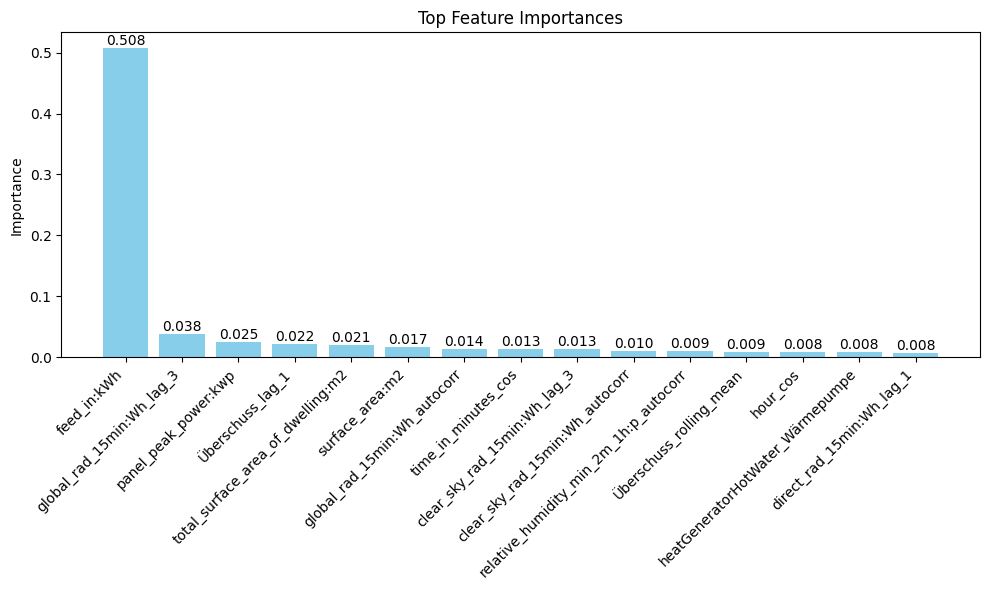

In [7]:
importances = model.feature_importances_
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f'feature_{i}' for i in range(X_train.shape[1])]
# Sortieren
sorted_idx = np.argsort(importances)[::-1]
top_n = 15  # Anzahl der Top-Features

plt.figure(figsize=(10, 6))
bars = plt.bar(range(top_n), importances[sorted_idx][:top_n], color='skyblue')
plt.xticks(range(top_n), [feature_names[i] for i in sorted_idx][:top_n], rotation=45, ha='right')
plt.title('Top Feature Importances')
plt.ylabel('Importance')
plt.tight_layout()

# Werte über Balken anzeigen
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.3f}', ha='center', va='bottom')

plt.show()

As you can see, the feed in feature has the biggest impact on the final predicted value. also the global radiation and the panel peak power have good influences on the model. 

#### Model Without Feed-in Feature
As a rigorous test, we will attempt to forecast values without using the feed-in energy feature. This approach will help us understand the model's robustness and the importance of various features in making accurate predictions.


In [8]:
# remove feed in features 
ueberschuss_cols = [col for col in X_train.columns if 'Überschuss' in col]
cols_to_remove = ueberschuss_cols + ['feed_in:kWh']
cols_to_keep = [col for col in X_train.columns if col not in cols_to_remove]

X_train_scaled_without_feed_in = X_train_scaled[:, [X_train.columns.get_loc(col) for col in cols_to_keep]]
X_val_scaled_without_feed_in = X_val_scaled[:, [X_val.columns.get_loc(col) for col in cols_to_keep]]

In [9]:
# initialize XGBoost Regressor model
model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    objective='reg:squarederror'
)

# train model on scaled train data
model.fit(X_train_scaled_without_feed_in, y_train)

# predict y with validation data
y_pred_wo_feed_in = model.predict(X_val_scaled_without_feed_in)

# measure performance values
mse = mean_squared_error(y_val, y_pred_wo_feed_in)
r2 = r2_score(y_val, y_pred_wo_feed_in)
mae = mean_absolute_error(y_val, y_pred)

print(f"Validation MSE: {mse:.4f}")
print(f"Validation R2: {r2:.4f}")
print(f"Validation MAE: {mae:.4f}")

Validation MSE: 0.7434
Validation R2: 0.7546
Validation MAE: 0.2207


In [10]:
# Optional: save model
# model.save_model("02_TrainedModels/xgb_regressor_model_without_feed_in.json")

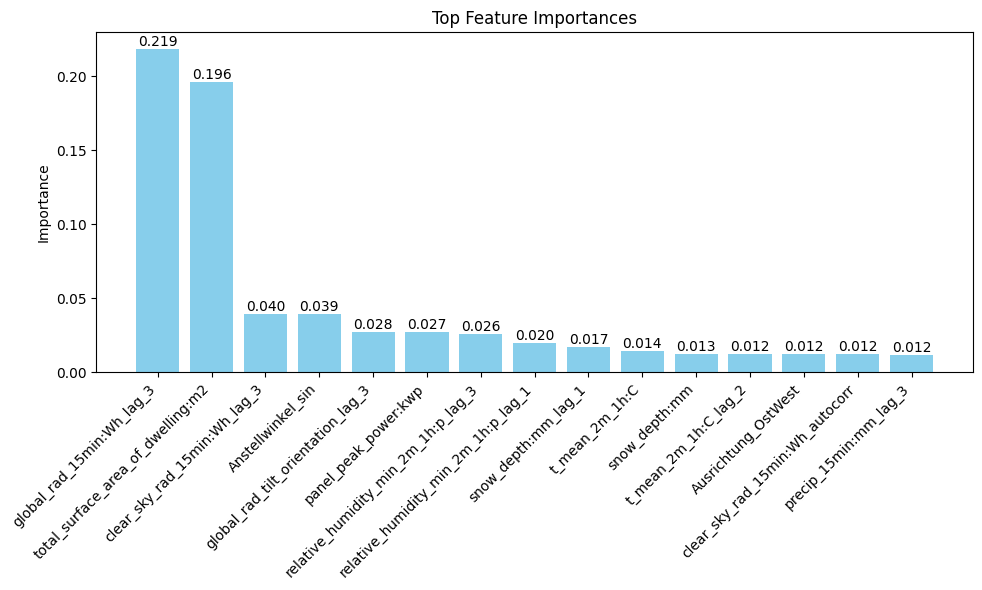

In [11]:
importances = model.feature_importances_
feature_names = cols_to_keep

# Sortieren
sorted_idx = np.argsort(importances)[::-1]
top_n = 15  # Anzahl der Top-Features

plt.figure(figsize=(10, 6))
bars = plt.bar(range(top_n), importances[sorted_idx][:top_n], color='skyblue')
plt.xticks(range(top_n), [feature_names[i] for i in sorted_idx][:top_n], rotation=45, ha='right')
plt.title('Top Feature Importances')
plt.ylabel('Importance')
plt.tight_layout()

# Werte über Balken anzeigen
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.3f}', ha='center', va='bottom')

plt.show()

As you can see the model performs worse, because very important features are missing now. The key discipline is to improve this model. To visualize the model's performance, we will create scatter plots comparing the true values against the predicted values for both the model with and without the feed-in feature. This visualization will help us understand the model's accuracy and areas for improvement.

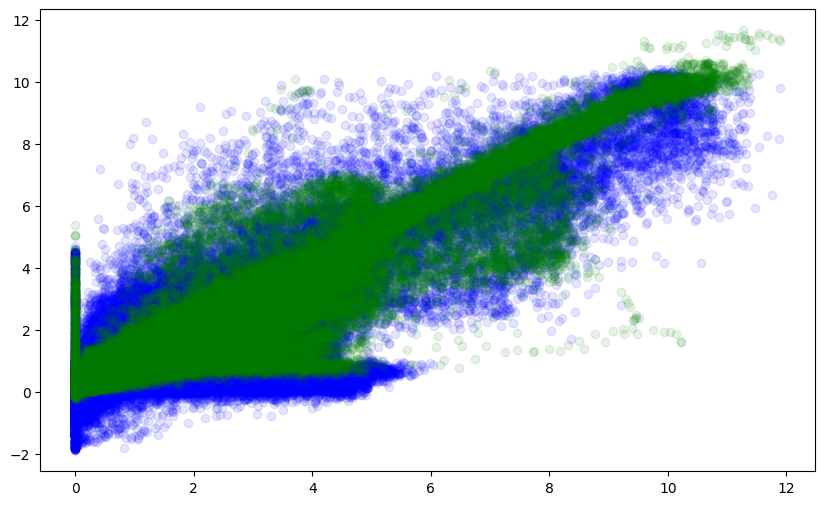

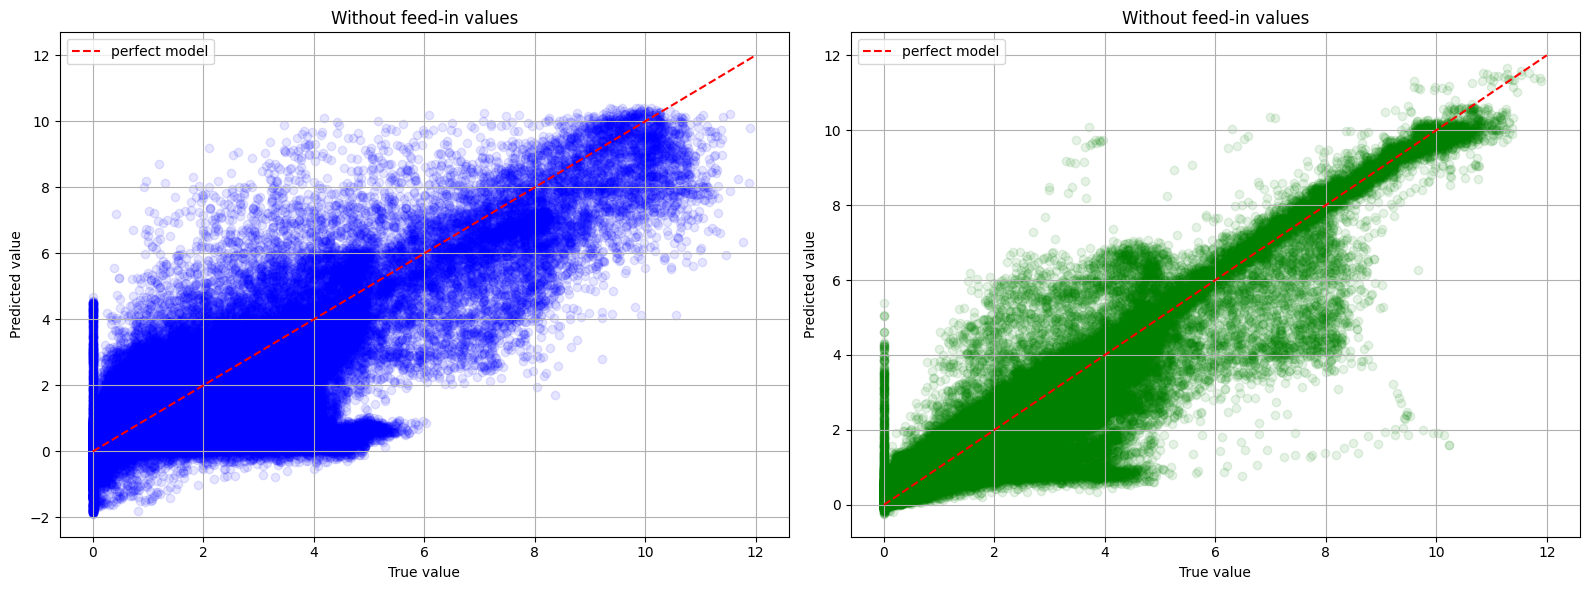

In [12]:
# make a scatterplot to visualize the true vs the predicted values of both models
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred_wo_feed_in, alpha=0.1, color='blue', label='Without feed-in values')
plt.scatter(y_val, y_pred, alpha=0.1, color='green', label='With feed-in values')
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# without feed in feature
axes[0].scatter(y_val, y_pred_wo_feed_in, alpha=0.1, color='blue')
axes[0].plot([0, 12], [0, 12], linestyle='--', color='red', label='perfect model')
axes[0].set_title('Without feed-in values')
axes[0].set_xlabel('True value')
axes[0].set_ylabel('Predicted value')
axes[0].legend()
axes[0].grid()

# model with feed in feature
axes[1].scatter(y_val, y_pred, alpha=0.1, color='green')
axes[1].plot([0, 12], [0, 12], linestyle='--', color='red', label='perfect model')
axes[1].set_title('Without feed-in values')
axes[1].set_xlabel('True value')
axes[1].set_ylabel('Predicted value')
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()